# Data Scientist Technical Assessment
### Candidate: Patricia Song

This notebook contains the detailed procedure of all the tasks required in `instructions.md` to predict cognitive test scores of preschoolers given characteristics of their mothers.
This notebook reads in `./data/data.txt` and output all related files in `./output`.

## Task 1. Prepare the data, rename variables as you see fit and justify. Propose the types of data for each variable (python data types).

### Importing packages

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import seaborn as sns
import scipy as sp
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.stattools import durbin_watson
import math

sns.set(style="darkgrid")


### Data Loading

In [2]:
# The data.txt is not utf-8 encoded so we used latin1/ISO-8859-1 as encoding 
raw_data = pd.read_csv('data.txt',sep='|',encoding= 'latin1') #

# Rename the columns by only changing the unrecognized column into `ind`, meaning index
raw_data.columns=['ind','variable','value']

print('Display the first 5 rows of the raw data:')
raw_data.head()

Display the first 5 rows of the raw data:


,ind,variable,value
0,0,score,65
1,1,score,98
2,2,score,85
3,3,score,83
4,4,score,115


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2171 entries, 0 to 2170
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ind       2171 non-null   object
 1   variable  2171 non-null   object
 2   value     2171 non-null   object
dtypes: object(3)
memory usage: 51.0+ KB


In [4]:
raw_data.variable.value_counts()

score      434
h          434
i          434
w          434
a          434
áº      1
Name: variable, dtype: int64

In [5]:
raw_data[raw_data["variable"].isin(['score','h','i','w','a'])==False]

,ind,variable,value
894,0xC0,áº,áº


- By checking the overall info of the raw data. We can see there's no missing/null values. 

- By checking ...   The column `variable` contains all the 5 variables we need for later tasks.

### Rename Variables

#### Data dictionary:

i - mother's IQ

a - mother's age at child's birth

h - indicator showing whether mother completed high school (1=True, 0=False)

w = 1: mother did not work in first three years of child’s life

w = 2: mother worked in second or third year of child’s life

w = 3: mother worked part-time in first year of child’s life

w = 4: mother worked full-time in first year of child’s life

score - child's IQ (regressand)


In [6]:
data = pd.DataFrame()
data['child_IQ'] = raw_data.loc[raw_data['variable']=='score','value'].reset_index(drop = True)
data['mother_IQ'] = raw_data.loc[raw_data['variable']=='i','value'].reset_index(drop = True)
data['mother_Age'] = raw_data.loc[raw_data['variable']=='a','value'].reset_index(drop = True)
data['mother_HighSchool'] = raw_data.loc[raw_data['variable']=='h','value'].reset_index(drop = True)
data['mother_Work'] = raw_data.loc[raw_data['variable']=='w','value'].reset_index(drop = True)
print((data.dtypes))
(data.head())

child_IQ             object
mother_IQ            object
mother_Age           object
mother_HighSchool    object
mother_Work          object
dtype: object


,child_IQ,mother_IQ,mother_Age,mother_HighSchool,mother_Work
0,65,'121.117528602603',27,1,4
1,98,'89.3618817100663',25,1,4
2,85,'115.443164881725',27,1,4
3,83,'99.4496394360723',25,1,3
4,115,'92.7457099982118',27,1,4


## Task 2. Transform the data so it's easy to analyze - describe what you did and why

In [7]:
data_new = data.copy()
data_new['mother_IQ'] = data['mother_IQ'].str.strip("'")#.str.replace(r"^'|'$", "")
data_new = data_new.astype({'mother_IQ':float,'mother_Age':int,
                            'mother_HighSchool':'category','mother_Work':'category',
                            'child_IQ':float})
print((data_new.dtypes))
data_new.head()

child_IQ              float64
mother_IQ             float64
mother_Age              int64
mother_HighSchool    category
mother_Work          category
dtype: object


,child_IQ,mother_IQ,mother_Age,mother_HighSchool,mother_Work
0,65.0,121.117529,27,1,4
1,98.0,89.361882,25,1,4
2,85.0,115.443165,27,1,4
3,83.0,99.449639,25,1,3
4,115.0,92.745710,27,1,4


In [8]:
data_new['mother_Work'].replace({'1':'None',
                                 '2':'2nd_3rd_year',
                                 '3':'1st_year_parttime',
                                 '4':'1st_year_fulltime'},inplace=True)
data_new['mother_HighSchool'].replace({'0':'Incompleted',
                                       '1':'Completed'},inplace=True)

#### Data Validation

In [9]:
### Check the missing value of the data 
data_new.isnull().sum()

child_IQ             0
mother_IQ            0
mother_Age           0
mother_HighSchool    0
mother_Work          0
dtype: int64

In [10]:
### Check the duplicates
print('There exists', data_new.duplicated().sum(),'duplicated data in the data set')
data_new[data_new.duplicated()]

There exists 1 duplicated data in the data set


,child_IQ,mother_IQ,mother_Age,mother_HighSchool,mother_Work
426,104.0,124.514635,23,Completed,1st_year_fulltime


Considering the size of the data is only 434, and due to lack of knowledge of the original data source and data index, it's better to keep the only duplicated record in following data analysis and modeling.

In [11]:
### Check basic statistics of the dataframe
data_new.describe()

,child_IQ,mother_IQ,mother_Age
count,434.000000,434.000000,434.000000
mean,86.797235,100.000000,22.785714
std,20.410688,15.000000,2.701070
min,20.000000,71.037405,17.000000
25%,74.000000,88.660321,21.000000
50%,90.000000,97.915254,23.000000
75%,102.000000,110.272742,25.000000
max,144.000000,138.893106,29.000000


#### Create a pandas profile report if needed

In [12]:
prof = ProfileReport(data_new)
prof.to_file(output_file='./output/pandasprofille.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 208.25it/s]


#### Create the dataframe for later linear regression model

Performed one-hot encoding here because even though we can use categorical variables directly in later modeling part, it's more convenient if we need to drop/add columns in stepwise linear regression

In [13]:
# Drop first column to avoid multicolinearity

df = pd.get_dummies(data_new,drop_first=True)#drop_first=True
df.head()

,child_IQ,mother_IQ,mother_Age,mother_HighSchool_Completed,mother_Work_2nd_3rd_year,mother_Work_1st_year_parttime,mother_Work_1st_year_fulltime
0,65.0,121.117529,27,1,0,0,1
1,98.0,89.361882,25,1,0,0,1
2,85.0,115.443165,27,1,0,0,1
3,83.0,99.449639,25,1,0,1,0
4,115.0,92.745710,27,1,0,0,1


## Task 3. Perform the exploratory data analysis

### Target Variable: child's IQ

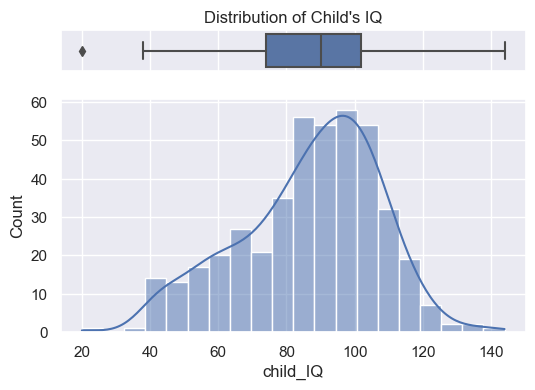

In [14]:
fig,axs=plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)},dpi=100)
ax_box=sns.boxplot(data=data_new,x='child_IQ',ax=axs[0])
sns.histplot(data=data_new,x='child_IQ',bins=20,kde=True, ax=axs[1])
ax_box.set(xlabel='')
axs[0].set_title("Distribution of Child's IQ")
plt.show()

### Numeric variables

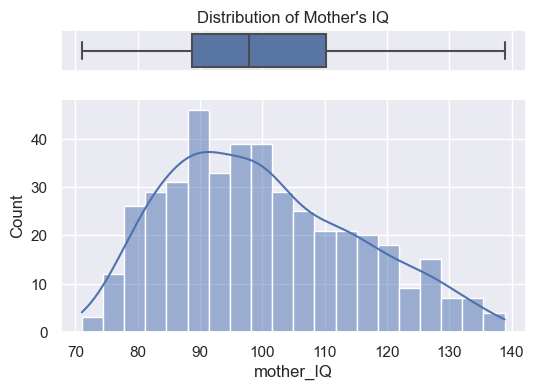

In [15]:
# Distribution and Outlier Detection
fig,axs=plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)},dpi=100)
ax_box=sns.boxplot(data=data_new,x='mother_IQ',ax=axs[0])
sns.histplot(data=data_new,x='mother_IQ',bins=20,kde=True, ax=axs[1])
ax_box.set(xlabel='')
axs[0].set_title("Distribution of Mother's IQ")
plt.show()

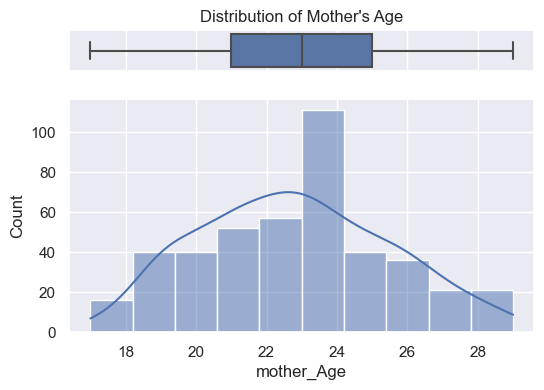

In [16]:
fig,axs=plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)},dpi=100)
ax_box=sns.boxplot(data=data_new,x='mother_Age',ax=axs[0])
sns.histplot(data=data_new,x='mother_Age',bins=10,kde=True, ax=axs[1])
ax_box.set(xlabel='')
axs[0].set_title("Distribution of Mother's Age")
plt.show()

#### Relationship with numerical variables

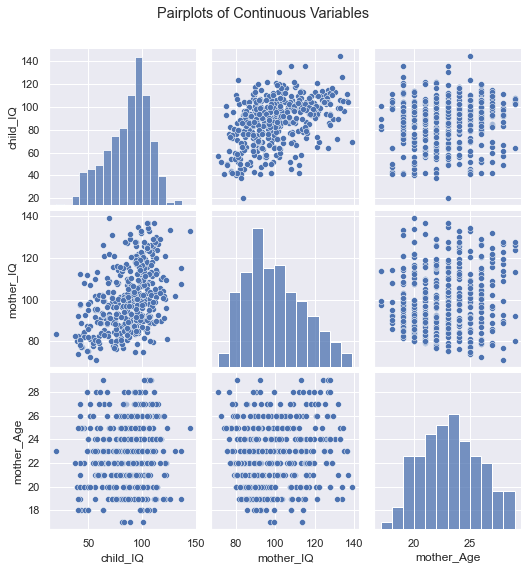

In [17]:
pp = sns.pairplot(data_new, height = 2.5)
pp.fig.suptitle("Pairplots of Continuous Variables",y=1.05)
plt.show()

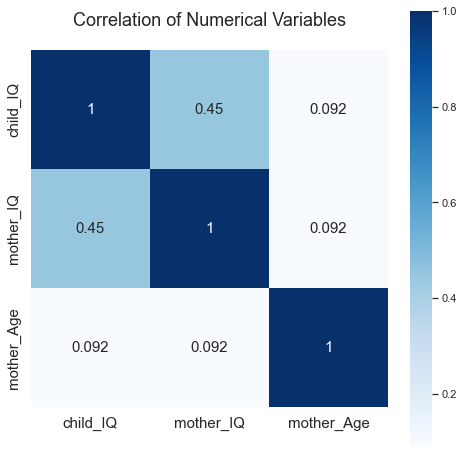

In [18]:
corrmat = data_new.corr()
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corrmat, vmax=1,  annot=True,square=True,cmap='Blues',annot_kws={"size": 15})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 15)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 15)
plt.title('Correlation of Numerical Variables', fontsize = 18,y=1.05)
plt.show()

Based on the pairplot and correlation heatmap, Child's IQ is highly correlated with Mother'IQ.

### Categorical Variables

#### Working Status

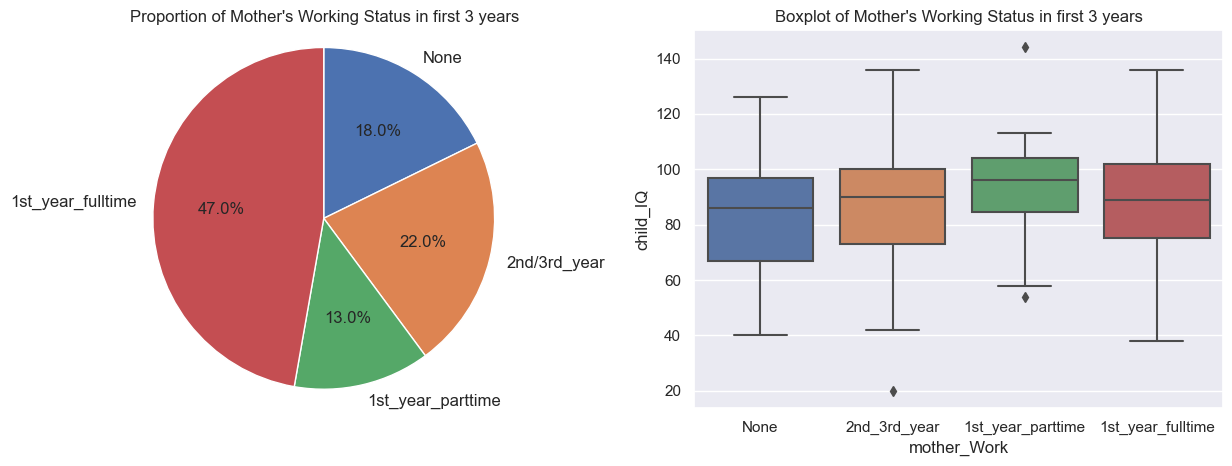

In [19]:
fig,ax=plt.subplots(1,2,figsize=(15,5),dpi=100)

explode = (0, 0, 0, 0) 
_, _, autotexts =ax[0].pie(data_new['mother_Work'].value_counts()[['None', '2nd_3rd_year', '1st_year_parttime', '1st_year_fulltime']], explode=explode, 
                        labels=['None', '2nd/3rd_year', '1st_year_parttime', '1st_year_fulltime'], 
                        autopct=lambda p: '{:.1f}%'.format(round(p)) if p > 1 else ' ',counterclock=False,
                        startangle=90,
        shadow=False,textprops={'fontsize':12})
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
sns.boxplot(x='mother_Work', y="child_IQ", data=data_new,ax=ax[1])
ax[0].set_title("Proportion of Mother's Working Status in first 3 years")
ax[1].set_title("Boxplot of Mother's Working Status in first 3 years")

plt.show()

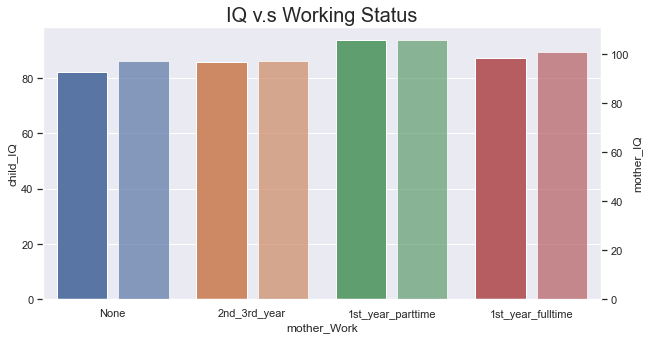

In [20]:
df_bar = data_new.groupby(['mother_Work'])[['child_IQ','mother_IQ','mother_Age']].mean().reset_index()
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=df_bar["mother_Work"], y=df_bar["child_IQ"],alpha=1)
width_scale = 0.45
for bar in ax.containers[0]:
    bar.set_width(bar.get_width() * width_scale)
    
ax2 = ax.twinx()
ax2.grid(False)

sns.barplot(x=df_bar["mother_Work"], y=df_bar["mother_IQ"],ax=ax2,alpha=0.7)
for bar in ax2.containers[0]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1- width_scale))
    bar.set_width(w * width_scale)
plt.title('IQ v.s Working Status',fontsize=20)
plt.show()


47% of the mothers worked full time in the fist year of child's life.

Mothers who worked part time in the fist year of child's life tends to have higher IQ and their child's IQ is slightly higher.

#### High School Completing Status

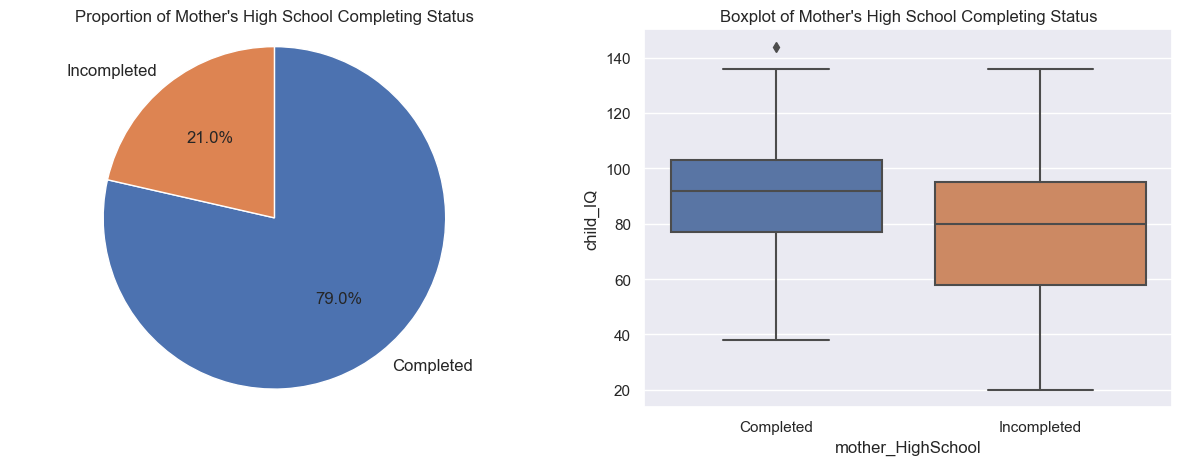

In [21]:
fig,ax=plt.subplots(1,2,figsize=(15,5),dpi=100)

explode = (0, 0,) 
_, _, autotexts =ax[0].pie(data_new['mother_HighSchool'].value_counts()[['Completed', 'Incompleted']], explode=explode, 
                        labels=['Completed', 'Incompleted'], 
                        autopct=lambda p: '{:.1f}%'.format(round(p)) if p > 1 else ' ',counterclock=False,
                        startangle=90,
        shadow=False,textprops={'fontsize':12})
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
sns.boxplot(x='mother_HighSchool', y="child_IQ", data=data_new,ax=ax[1],order=['Completed', 'Incompleted'])
ax[0].set_title("Proportion of Mother's High School Completing Status")
ax[1].set_title("Boxplot of Mother's High School Completing Status")
plt.show()

79% of the mothers have completed high school, and their child's IQ is clearly higher than those didn't completed high school according the boxplot.

## Task 4. Perform a linear regression where the regressand is child's IQ
    A. using a single predictor
    B. using multiple predictors
    C. using multiple predictors with an interaction term
   
    For each case, explain your model, model assumptions and how to interpret the regression coefficients.

### 4.0 Model Assumptions

Linear regression model assumptions:

- **Linear relationship**: There exists a linear relationship between dependent variable and independent variables.
- **Normality**: Residuals are normally distributed.
- **Homoscedasticity**: Residuals have the same constant variance.
- **No auto-correlation**: There is no autocorrelation between residuals.
- **No/low multicollinearity**(Multiple Predictors): Predictors are not correlated with each other.



#### Train Test Split

In [22]:
# split the data into training and testing sets
train, test = train_test_split(df, random_state = 0, test_size=0.2)

### 4.1 Single predictor

#### Modeling

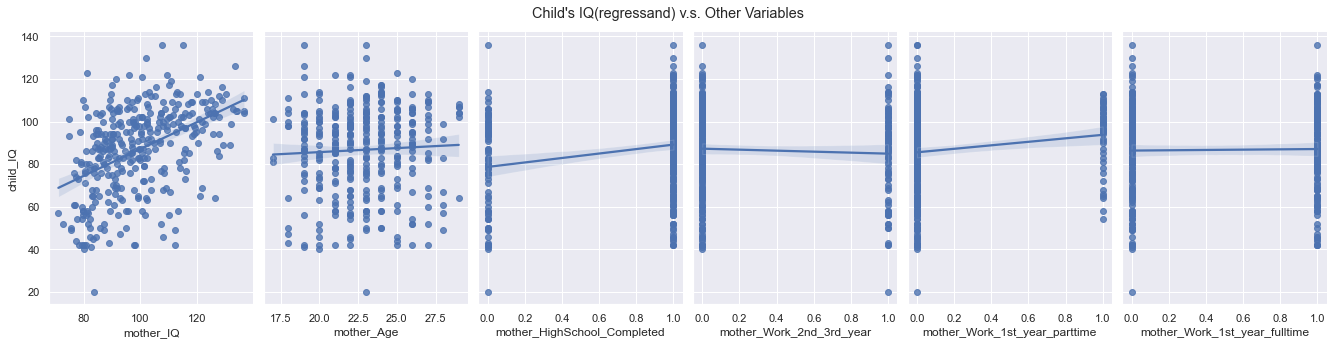

In [23]:
pp2 = sns.pairplot(train, x_vars=['mother_IQ','mother_Age','mother_HighSchool_Completed','mother_Work_2nd_3rd_year','mother_Work_1st_year_parttime','mother_Work_1st_year_fulltime'], y_vars='child_IQ', height=4.5, aspect=0.7,kind='reg')
pp2.fig.suptitle("Child's IQ(regressand) v.s. Other Variables",y=1.05)
plt.show()


According to the pairplot above that shows relationship between the child's IQ(regressand) and other numerical variables,  mother's IQ clearly has a more obvious linear relationship with the regressand. In the single predictor model, we choose the mother's IQ as predictor variable.

$$Child\_IQ = \beta_0 + \beta_1Mother\_IQ + \epsilon \;\;\;\; \text{where} \; \epsilon \sim N(0,\sigma^2)$$

In [24]:
model1 = smf.ols('child_IQ~mother_IQ',data=train).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               child_IQ   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     92.88
Date:                Sun, 15 Jan 2023   Prob (F-statistic):           1.27e-19
Time:                        00:32:25   Log-Likelihood:                -1498.9
No. Observations:                 347   AIC:                             3002.
Df Residuals:                     345   BIC:                             3009.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.0480      6.572      3.659      0.000      11.122      36.974
mother_IQ      0.6308      0.065      9.638      0.000       0.502       0.760
==============================================================================
Omnibus:                        7.270   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                7.304
Skew:                          -0.355   Prob(JB):                       0.0259
Kurtosis:                       3.027   Cond. No.                         674.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Check Model Assumptions

##### Linearity

Harvey-Collier multiplier test for Null hypothesis that the linear specification is correct: which tests whether recursive residuals have mean 0 (which they should under the null hypothesis of linearity)
with p value larger than 0.05 we can't reject the null hypothesis.

In case of a multiple linear regression, where we have more than one predictor, we plot the residual and the predicted or fitted value $\hat{y}$ .

In [25]:
def Linearity(model):
    print('\033[1mCheck for Linearity\033[0m')
    fig,ax=plt.subplots(1,2,figsize=(12,5),dpi=100)
    y_hat = model.predict(train)
    residuals = (train['child_IQ']-y_hat)
    #plot predicted vs actual
    ax[0].plot(y_hat,train['child_IQ'],'o')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')
    ax[0].set_title('Predicted vs. Actual')
    ax[0].plot(np.array(ax[0].get_xlim()),np.array(ax[0].get_xlim()),'-',color='red')
    _ = ax[1].scatter(y_hat,residuals)
    ax[1].plot(np.array(ax[1].get_xlim()),np.array([0,0]),'-',color='red')
    ax[1].set_xlabel('Predicted')
    ax[1].set_ylabel('Residuals')
    ax[1].set_title('Predicted vs. Residuals:')
    plt.show()
    if len(model.params)<3:
        name = ["t value", "p value"]
        hc = sms.linear_harvey_collier(model)
        lzip(name, test)  
        print('The result of Harvey-Collier multiplier test is',hc)
        if hc[1]>=0.05:
            print('We can not reject the null hypothesis that the recursive residuals have mean 0 and linear relationship exists')
        else: 
            print('We can reject the null hypotheisis and there is no linear relationship between regressand and predictors')

Check for Linearity


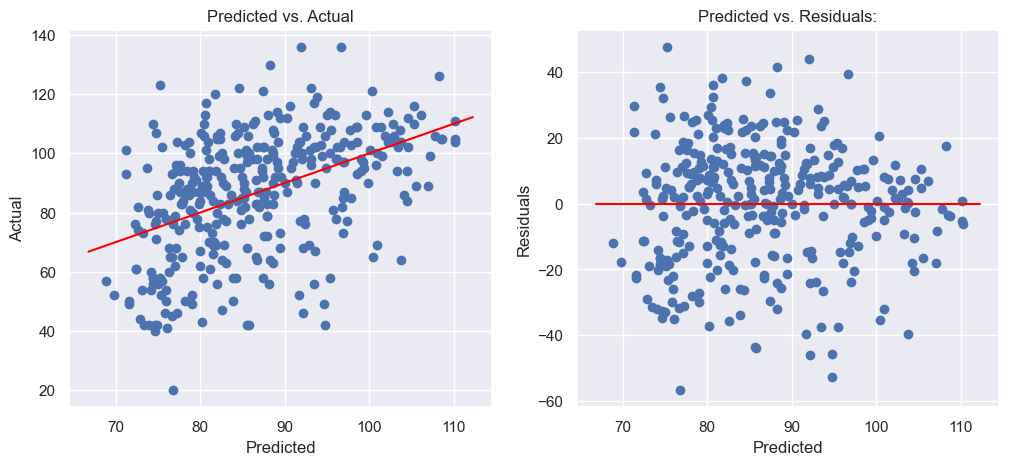

The result of Harvey-Collier multiplier test is Ttest_1sampResult(statistic=0.74063594627705, pvalue=0.45942090361800947)
We can not reject the null hypothesis that the recursive residuals have mean 0 and linear relationship exists


In [26]:
Linearity(model1)

##### Normality

Draw P-P plot, distribution of residuals and perform Anderson Darling Test to check the residuals are normally distributed with expectation==0.

There are also a variety of statistical tests for normality, including the Kolmogorov-Smirnov test, the Shapiro-Wilk test, the Jarque-Bera test, and the Anderson-Darling test.  

We use The Anderson-Darling test, because it is specific to the normal distribution (unlike the K-S test) and it looks at the whole distribution rather than just the skewness and kurtosis (like the J-B test). 

In [27]:
def Normality(model):
    print('\033[1mCheck for Normality\033[0m')
    fig,ax=plt.subplots(1,2,figsize=(12,5),dpi=100)
    y_hat = model.predict(train)
    residuals = (train['child_IQ']-y_hat)
    #plot predicted vs actual   
    _, (__, ___, r) = sp.stats.probplot(residuals, plot=ax[0], fit=True)
    sns.histplot(residuals,kde=True,ax=ax[1])
    ax[1].set_title('Normality of error terms/residuals')
    plt.show()
    mean_residuals = np.mean(residuals)
    print("Mean of Residuals {}".format(mean_residuals))
    print('The p value of the Anderson-Darling test is',normal_ad(residuals)[1])
    if (normal_ad(residuals)[1])<0.05:
        print('The residuals are not normally distributed')
    else:
        print('The residuals are normally distributed')
    
    

Check for Normality


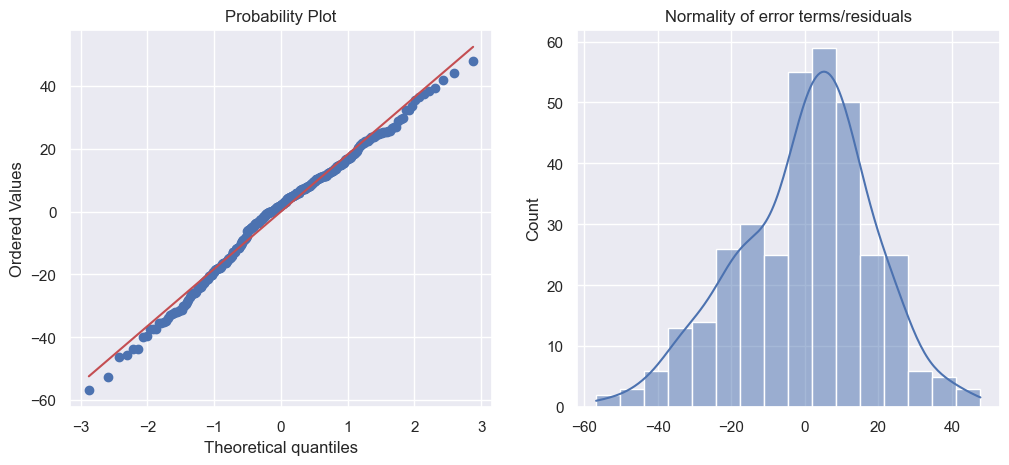

Mean of Residuals -1.847001578258243e-14
The p value of the Anderson-Darling test is 0.00010659481319760005
The residuals are not normally distributed


In [28]:
Normality(model1)

##### Homoscedasticity

Goldfeld Quandt Test

Using Goldfeld Quandt to check for heteroscedasticity.

Null Hypothesis: Error terms are homoscedastic

Alternative Hypothesis: Error terms are heteroscedastic.

In [29]:
def Homoscedasticity(model):
    print('\033[1mCheck for Homoscedasticity\033[0m')
    fig,ax=plt.subplots(1,figsize=(6,5),dpi=100)
    y_hat = model.predict(train)
    residuals = (train['child_IQ']-y_hat)
    #plot predicted vs residuals
    _ = ax.scatter(y_hat,residuals)
    ax.plot(np.array(ax.get_xlim()),np.array([0,0]),'-',color='red')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Residuals')
    ax.set_title('Predicted vs. Residuals:')
    plt.show()
    name = ['F statistic', 'p-value']
    gq = sms.het_goldfeldquandt(residuals, train)
    lzip(name, gq)
    if gq[1]>0.05:
        print('The result of the Goldfeld Quandt test is',gq)
        print('We can not reject the null hypothesis that the residuals are homoscedastic')


Check for Homoscedasticity


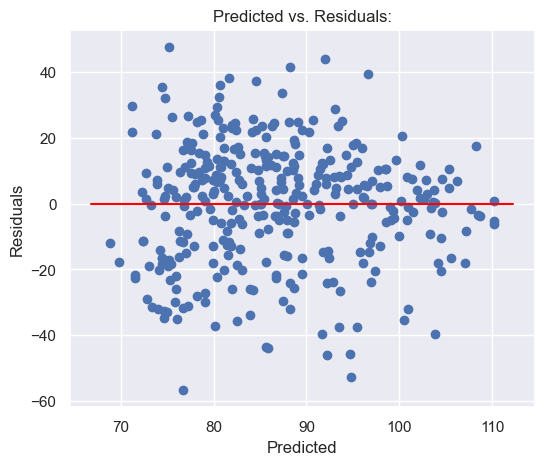

The result of the Goldfeld Quandt test is (0.9301039337543225, 0.6795925973373863, 'increasing')
We can not reject the null hypothesis that the residuals are homoscedastic


In [30]:
Homoscedasticity(model1)

##### Auto-correlation

Using residual plots and Durbin Watson test to check auto-correlation in residuals.

H0 (null hypothesis): There is no correlation among the residuals.

HA (alternative hypothesis): The residuals are autocorrelated.

Check for Autocorrelation


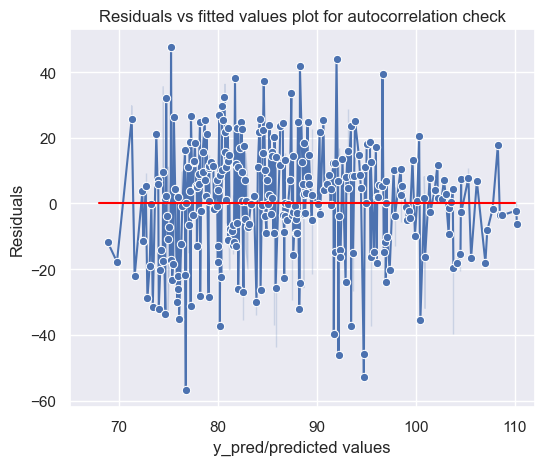

Durbin-Watson: 1.8465425773379336
There is little to no autocorrelation in residuals


In [31]:
def Autocorrelation(model):
    print('\033[1mCheck for Autocorrelation\033[1m')
    fig,ax=plt.subplots(1,figsize=(6,5),dpi=100)
    y_hat = model.predict(train)
    residuals = (train['child_IQ']-y_hat)
    autodf =pd.DataFrame({'x': y_hat,'y':residuals})
    p = sns.lineplot(data=autodf,x='x',y='y',marker='o')
    plt.xlabel('y_pred/predicted values')
    plt.ylabel('Residuals')
    plt.xlim(65,112)
    p = sns.lineplot(x=[68,110],y=[0,0],color='red')
    p = plt.title('Residuals vs fitted values plot for autocorrelation check')
    plt.show()
    durbinWatson = durbin_watson(residuals)
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('There might exist positive autocorrelation')
    elif durbinWatson > 2.5:
        print('There might exist negative autocorrelation')
    else:
        print('There is little to no autocorrelation in residuals')
Autocorrelation(model1)

#### Model Interpretation

$$Child\_IQ = \beta_0 + \beta_1Mother\_IQ + \epsilon \;\;\;\; \text{where} \; \epsilon \sim N(0,\sigma^2)$$

In [32]:
model1.params

Intercept    24.048010
mother_IQ     0.630826
dtype: float64

The coefficient of Intercept ($\beta_0$) is:  24.0,

 meaning when all other variables in the model are 0, the child's IQ is predicted to be 24.0


The coefficient of mother_IQ ($\beta_1$) is:  0.631,

 meaning by increasing 1 unit of mother_IQ the child's IQ increase 0.631 units with other variables fixed

In [33]:
model1.pvalues

Intercept    2.926191e-04
mother_IQ    1.271213e-19
dtype: float64

The p-value of intercept and mother_IQ is both lower than 0.05, meaning the mother_IQ is statistically siginicant at the significance level of 0.05

#### Evaluation Metrics

In [34]:
def metrics(model):
    n= len(train)
    p = 1
    y_train_predicted = model.predict(train)
    y_train = train['child_IQ']
    y_test_predicted = model.predict(test)
    y_test = test['child_IQ']
    metric=pd.DataFrame(columns=['train','test'],index=['mse','rmse','mae','R^2','Adj_R^2'])
    metric.loc['mse','train'] = mean_squared_error(y_train, y_train_predicted)
    metric.loc['rmse','train'] = math.sqrt(mean_squared_error(y_train, y_train_predicted))
    metric.loc['mae','train'] = mean_absolute_error(y_train, y_train_predicted)
    metric.loc['R^2','train'] = r2_score(y_train, y_train_predicted)
    metric.loc['Adj_R^2','train'] = model.rsquared_adj
    metric.loc['mse','test'] = (mean_squared_error(y_test, y_test_predicted))
    metric.loc['rmse','test'] = (math.sqrt(mean_squared_error(y_test, y_test_predicted)))
    metric.loc['mae','test'] = (mean_absolute_error(y_test, y_test_predicted))
    metric.loc['R^2','test'] = r2_score(y_test, y_test_predicted)
    metric.loc['Adj_R^2','test'] = 1- ((1-r2_score(y_test, y_test_predicted)) * (n-1)/(n-p-1))

    return metric


In [35]:
metric_1 = metrics(model1)
metric_1

,train,test
mse,330.735717,338.650964
rmse,18.186141,18.402472
mae,14.324302,14.911319
R^2,0.21212,0.150906
Adj_R^2,0.209837,0.148445


### 4.2 Multiple predictors

#### Modeling

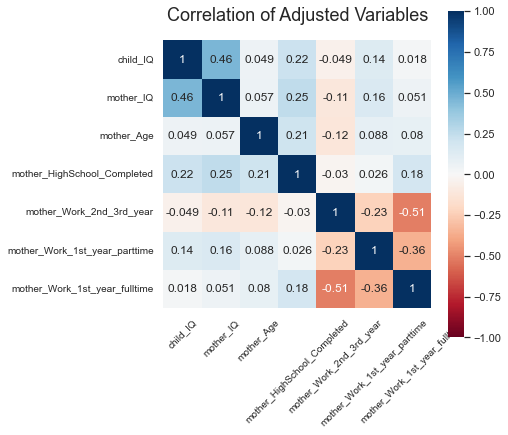

In [36]:
def plot_correlation(data):
    corrmat = data.corr()
    hmf, hmax = plt.subplots(figsize=(6, 6))
    hmax = sns.heatmap(corrmat, vmax=1,vmin=-1,  annot=True,square=True,cmap='RdBu',annot_kws={"size": 12})
    hmax.set_xticklabels(hmax.get_xmajorticklabels(), fontsize = 10)
    hmax.set_yticklabels(hmax.get_ymajorticklabels(), fontsize = 10)
    plt.title('Correlation of Adjusted Variables', fontsize = 18,y=1.05)
    plt.xticks(rotation=45) 
    plt.show()
plot_correlation(train)

Based on the correlation heatmap the columns 'mother_Work_1st_year_fulltime' and 'mother_Work_2nd_3rd_year', have the least correlation with the Child's IQ(regressand), and the two variables are highly correlated with each other. So we assume they should be excluded in our model. The column 'mother_Age' also has very small correlation with the target variable. Which should be excluded. 

However, we decided to check out the model with all features first since it's not to complicated.

In [37]:
formula = 'child_IQ ~ mother_IQ+mother_Work_2nd_3rd_year+\
mother_Work_1st_year_parttime+\
mother_Work_1st_year_fulltime+\
mother_HighSchool_Completed+mother_Age'
model2_1 = smf.ols(formula,train).fit()
model2_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               child_IQ   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     16.77
Date:                Sun, 15 Jan 2023   Prob (F-statistic):           5.76e-17
Time:                        00:32:29   Log-Likelihood:                -1495.3
No. Observations:                 347   AIC:                             3005.
Df Residuals:                     340   BIC:                             3032.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        24.1768     10.833      2.232      0.026       2.869      45.485
mother_IQ                         0.5797      0.068      8.467      0.000       0.445       0.714
mother_Work_2nd_3rd_year          1.6195      3.110      0.521      0.603      -4.497       7.736
mother_Work_1st_year_parttime     5.1408      3.601      1.428      0.154      -1.941      12.223
mother_Work_1st_year_fulltime     1.0372      2.859      0.363      0.717      -4.586       6.660
mother_HighSchool_Completed       5.0700      2.492      2.034      0.043       0.168       9.972
mother_Age                       -0.0218      0.380     -0.057      0.954      -0.769       0.725
==============================================================================
Omnibus:                        5.517   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.063   Jarque-Bera (JB):                5.566
Skew:                          -0.309   Prob(JB):                       0.0618
Kurtosis:                       2.948   Cond. No.                     1.15e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As we assumed, the p-value of the following three variables are high enough for us to drop in the refined model. We will keep the feature 'mother_Work_1st_year_parttime' since the p-value is not irrationally high and the coefficient is large.


\begin{equation*}
\begin{split}
Child\_IQ &= \beta_0 + \beta_1Mother\_IQ + \beta_2mother\_Work\_1st\_year\_parttime \\
&+\beta_3mother\_HighSchool\_Completed + \epsilon \;\;\;\; \\
&\text{where} \; \epsilon \sim N(0,\sigma^2)
\end{split}
\end{equation*}




In [38]:
formula = 'child_IQ ~ mother_IQ+mother_Work_1st_year_parttime+mother_HighSchool_Completed'
model2_2 = smf.ols(formula,train).fit()
model2_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               child_IQ   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     33.72
Date:                Sun, 15 Jan 2023   Prob (F-statistic):           4.02e-19
Time:                        00:32:29   Log-Likelihood:                -1495.4
No. Observations:                 347   AIC:                             2999.
Df Residuals:                     343   BIC:                             3014.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        24.6742      6.556      3.764      0.000      11.779      37.569
mother_IQ                         0.5784      0.068      8.509      0.000       0.445       0.712
mother_Work_1st_year_parttime     4.1347      2.851      1.450      0.148      -1.473       9.742
mother_HighSchool_Completed       5.2472      2.365      2.219      0.027       0.595       9.899
==============================================================================
Omnibus:                        5.431   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.066   Jarque-Bera (JB):                5.502
Skew:                          -0.306   Prob(JB):                       0.0639
Kurtosis:                       2.928   Cond. No.                         678.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Check Model Assumptions

Check for Linearity


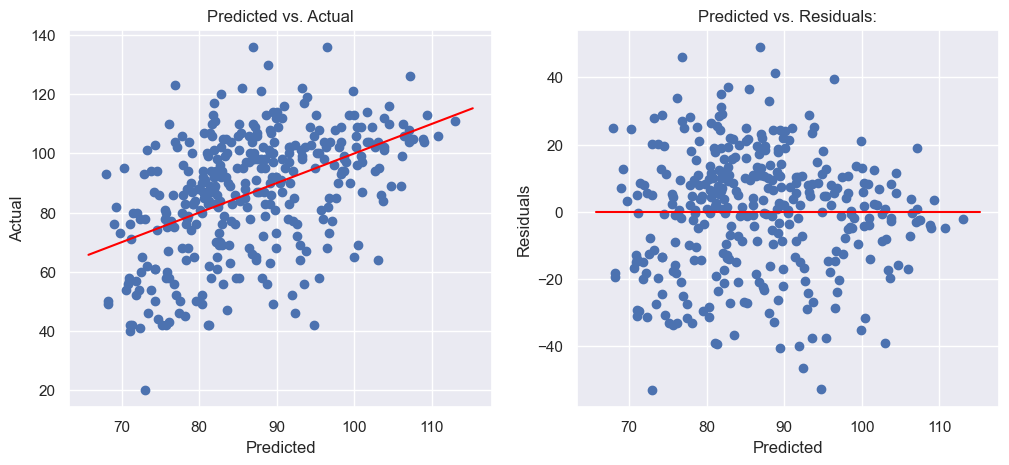



--------------------------------------------------------------------------------------------------------------


Check for Normality


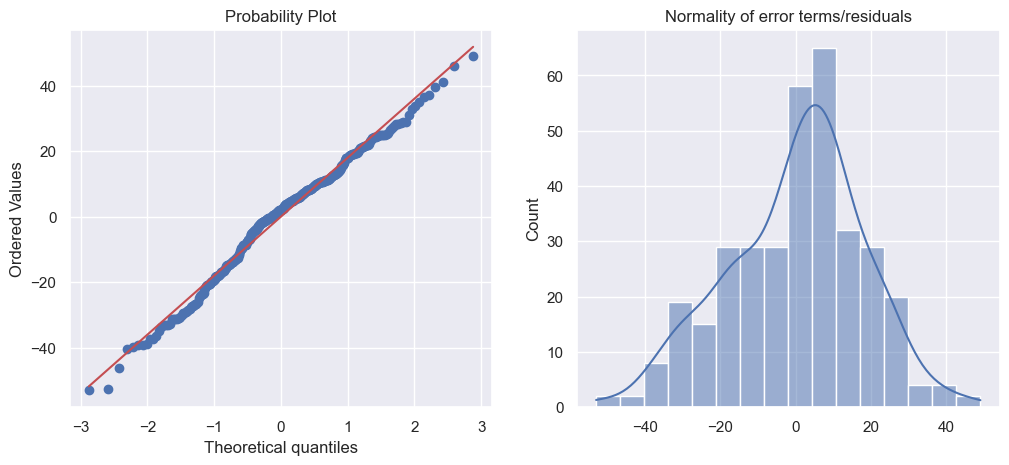

Mean of Residuals 2.384106360937996e-12
The p value of the Anderson-Darling test is 9.055779272565752e-05
The residuals are not normally distributed


--------------------------------------------------------------------------------------------------------------


Check for Homoscedasticity


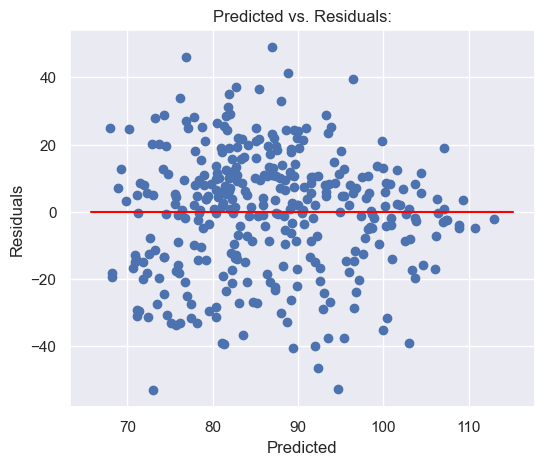

The result of the Goldfeld Quandt test is (0.9301039337543225, 0.6795925973373863, 'increasing')
We can not reject the null hypothesis that the residuals are homoscedastic


--------------------------------------------------------------------------------------------------------------


Check for Autocorrelation


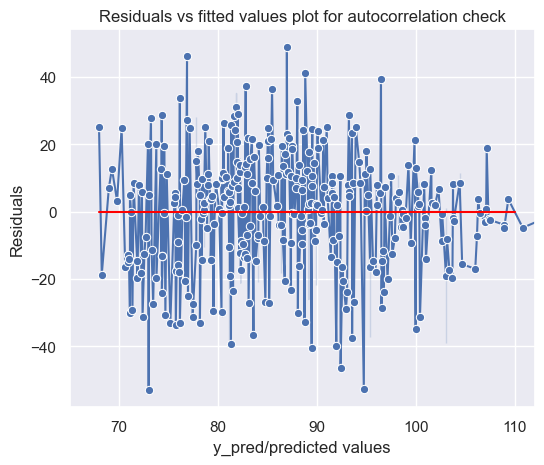

Durbin-Watson: 1.8811922805961985
There is little to no autocorrelation in residuals


In [39]:
Linearity(model2_2)
print("\n")
print("--------------------------------------------------------------------------------------------------------------")
print("\n")
Normality(model2_2)
print("\n")
print("--------------------------------------------------------------------------------------------------------------")
print("\n")
Homoscedasticity(model2_2)
print("\n")
print("--------------------------------------------------------------------------------------------------------------")
print("\n")
Autocorrelation(model2_2)

#### Multicolinearity

Using Corrrelation heatmap and VIF value to check multicolinearity

In [40]:
def Multicolinearity(model):
    print('\033[1mCheck for Multicolinearity\033[0m')
    plot_correlation(train)
    new_df = pd.DataFrame()
    if model.params[1:].index.str.contains(':').sum()>0:
        for i in model.params[1:].index.str.split(':'):
            new_df[":".join(i)]=train[i].prod(axis=1)
    else:
        new_df = train[model.params[1:].index]
  
    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = model.params.index[1:]
    
    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(new_df.values, i) for i in range(len(new_df.columns))]
    print(vif_data)
    print('\n')
    if (vif_data["VIF"]>5).sum()==0:
        print('There does not exist multicolinearity')
    elif (vif_data["VIF"]>10).sum()==0:
        print('There might exist multicolinearity')
    else:
        print('The variable',list(vif_data.query("VIF>10").feature),'are highly correlated')

   

Check for Multicolinearity


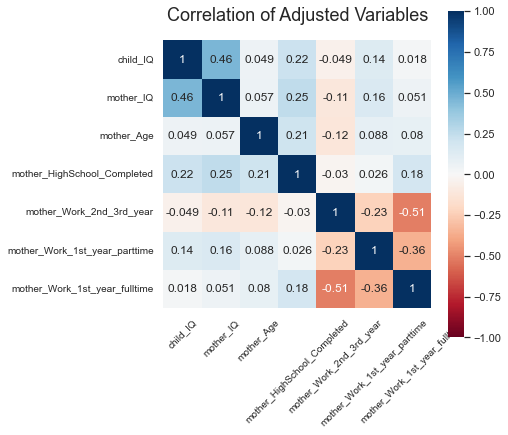

                         feature       VIF
0                      mother_IQ  4.721003
1  mother_Work_1st_year_parttime  1.178893
2    mother_HighSchool_Completed  4.518479


There does not exist multicolinearity


In [41]:
Multicolinearity(model2_2)

#### Model Interpretation

$$Child\_IQ = \beta_0 + \beta_1Mother\_IQ + \epsilon \;\;\;\; \text{where} \; \epsilon \sim N(0,\sigma^2)$$

In [42]:
model2_2.params

Intercept                        24.674193
mother_IQ                         0.578398
mother_Work_1st_year_parttime     4.134707
mother_HighSchool_Completed       5.247220
dtype: float64

The coefficient of Intercept ($\beta_0$) is:  24.7,

 meaning when all other variables in the model are 0, the child's IQ is predicted to be 24.7


The coefficient of mother_IQ ($\beta_1$) is:  0.578,

 meaning by increasing 1 unit of mother_IQ the child's IQ increase 0.578 units with other variables fixed

The coefficient of mother_Work_1st_year_parttime ($\beta_1$) is:  4.13,

 meaning when mother worked parttime in 1st year of child's life, the child's IQ is 4.13 units higher than the child's IQ whose mother didn't with other variables fixed.


The coefficient of mother_HighSchool_Completed ($\beta_3$) is:  5.25,

 meaning when mother Completed High School, the child's IQ is 5.25 units higher than the child's whose mother didn't complete high school with other variables fixed


In [43]:
model2_2.pvalues

Intercept                        1.970019e-04
mother_IQ                        5.518479e-16
mother_Work_1st_year_parttime    1.478815e-01
mother_HighSchool_Completed      2.716796e-02
dtype: float64

All variables have a relatively low p-value

The p-value of Intercept, mother_IQ, mother_HighSchool_Completed,  mother_IQ:mother_HighSchool_Completed is statistically significant at a significance level of 0.05.

#### Evaluation Metrics

In [44]:
print(model2_1.aic)
print(model2_2.aic)

3004.563800901802
2998.8500412097246


In [45]:
metric_2 = metrics(model2_2)
metric_2

,train,test
mse,324.17624,328.957106
rmse,18.004895,18.137175
mae,14.244781,14.812948
R^2,0.227746,0.175212
Adj_R^2,0.220992,0.172821


### 4.3 Multiple predictor with interaction terms

#### Modeling

In previous models, we have successfully concluded the effectiveness of certain variables such as `mother_IQ`, `mother_Work_1st_year_parttime`, and `mother_HighSchool_Completed`. By visualizing the scatter plot of child's IQ and mother's IQ stratified by whether the mother completed high school or not. We can see there might be a interaction of the `mother_IQ` and `mother_HighSchool_Completed` that can be considered into the model. When mother's IQ is low, the child's whose mother did complete high school tends to have a higher IQ. While when mother's IQ is high, the child's whose mother did not complete high school tends to have a higher IQ. However, we still want to include all the interactions and check the p-values and R squares first. 

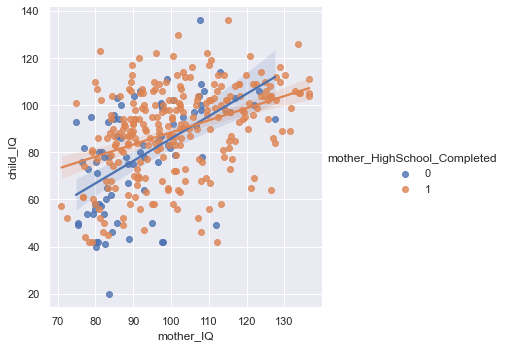

In [46]:
sns.lmplot(x='mother_IQ',y='child_IQ',hue='mother_HighSchool_Completed',data=train)
plt.show()


In [47]:
formula = 'child_IQ ~ mother_IQ*mother_Work_1st_year_parttime+\
mother_Work_1st_year_parttime*mother_HighSchool_Completed+\
mother_IQ*mother_HighSchool_Completed'
model3_1 = smf.ols(formula,train).fit()
model3_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               child_IQ   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     18.19
Date:                Sun, 15 Jan 2023   Prob (F-statistic):           2.51e-18
Time:                        00:32:33   Log-Likelihood:                -1492.0
No. Observations:                 347   AIC:                             2998.
Df Residuals:                     340   BIC:                             3025.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================
                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept                                                   -10.3237     14.891     -0.693      0.489     -39.613      18.966
mother_IQ                                                     0.9578      0.160      5.975      0.000       0.643       1.273
mother_Work_1st_year_parttime                                15.4411     19.898      0.776      0.438     -23.698      54.580
mother_IQ:mother_Work_1st_year_parttime                      -0.1257      0.197     -0.637      0.524      -0.514       0.262
mother_HighSchool_Completed                                  46.7004     16.526      2.826      0.005      14.195      79.206
mother_Work_1st_year_parttime:mother_HighSchool_Completed     2.3813      7.209      0.330      0.741     -11.798      16.560
mother_IQ:mother_HighSchool_Completed                        -0.4434      0.175     -2.537      0.012      -0.787      -0.100
==============================================================================
Omnibus:                        6.479   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                6.563
Skew:                          -0.336   Prob(JB):                       0.0376
Kurtosis:                       2.961   Cond. No.                     2.96e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As we assumed, only the `mother_IQ:mother_HighSchool_Completed` interaction shows a low p-value. So we eliminate the model features by filterling all the features with p-value less than 0.5. 
In adition, the task specified we consider only one interaction. So we choose to keep mother_IQ:mother_HighSchool_Completed


\begin{equation*}
\begin{split}
Child\_IQ &= \beta_0 + \beta_1Mother\_IQ + \beta_2mother\_Work\_1st\_year\_parttime \\
&+\beta_3mother\_HighSchool\_Completed \\
&+\beta_4Mother\_IQ*mother\_HighSchool\_Completed \\
& + \epsilon \;\;\;\; \text{where} \; \epsilon \sim N(0,\sigma^2)
\end{split}
\end{equation*}




In [48]:
formula = 'child_IQ ~ mother_IQ+mother_Work_1st_year_parttime+\
mother_IQ*mother_HighSchool_Completed'
model3_2 = smf.ols(formula,train).fit()
model3_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               child_IQ   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     27.30
Date:                Sun, 15 Jan 2023   Prob (F-statistic):           1.11e-19
Time:                        00:32:33   Log-Likelihood:                -1492.2
No. Observations:                 347   AIC:                             2994.
Df Residuals:                     342   BIC:                             3014.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -8.5623     14.610     -0.586      0.558     -37.300      20.175
mother_IQ                                 0.9376      0.157      5.986      0.000       0.629       1.246
mother_Work_1st_year_parttime             4.2163      2.829      1.491      0.137      -1.347       9.780
mother_HighSchool_Completed              46.5855     16.440      2.834      0.005      14.250      78.921
mother_IQ:mother_HighSchool_Completed    -0.4392      0.173     -2.541      0.012      -0.779      -0.099
==============================================================================
Omnibus:                        6.162   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                6.248
Skew:                          -0.328   Prob(JB):                       0.0440
Kurtosis:                       2.945   Cond. No.                     2.90e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The new model seems better than last one in metrics such as AIC and R^2.

#### Check Model Assumptions

Check for Linearity


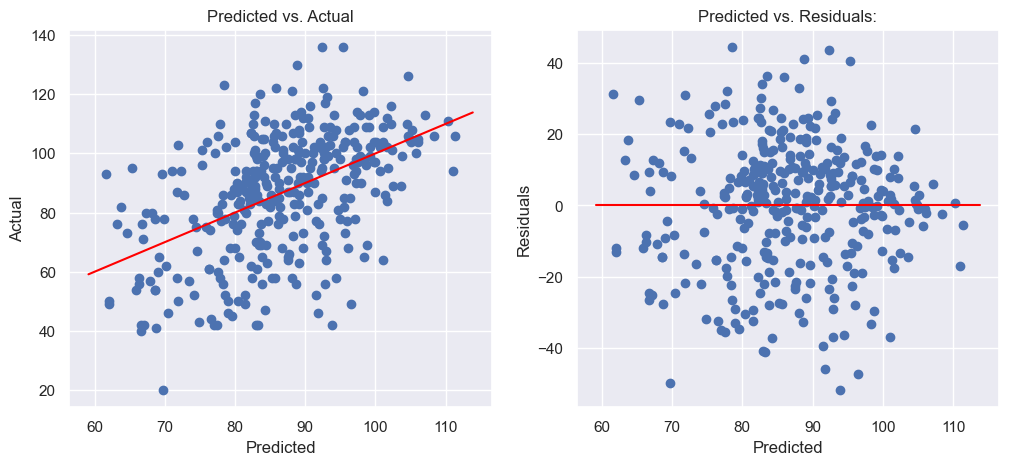



--------------------------------------------------------------------------------------------------------------


Check for Normality


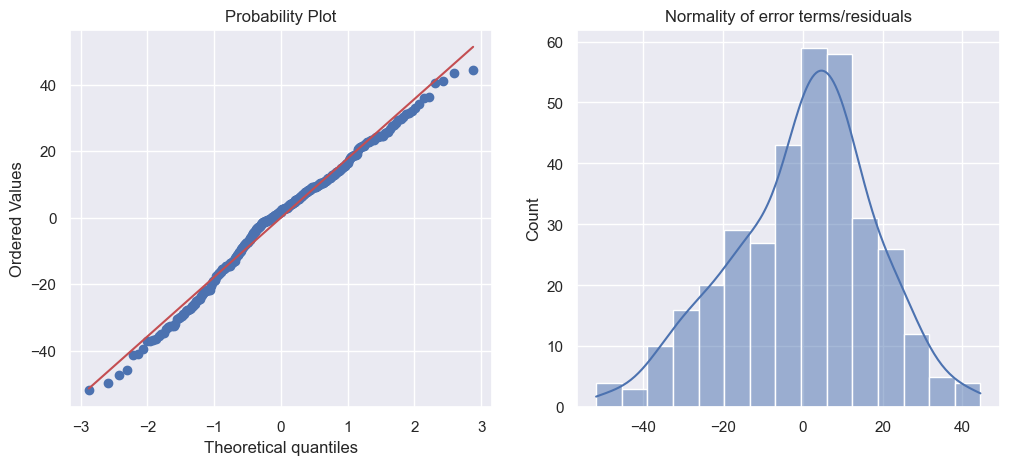

Mean of Residuals 1.4169901243400268e-14
The p value of the Anderson-Darling test is 0.00027307675108809246
The residuals are not normally distributed


--------------------------------------------------------------------------------------------------------------


Check for Homoscedasticity


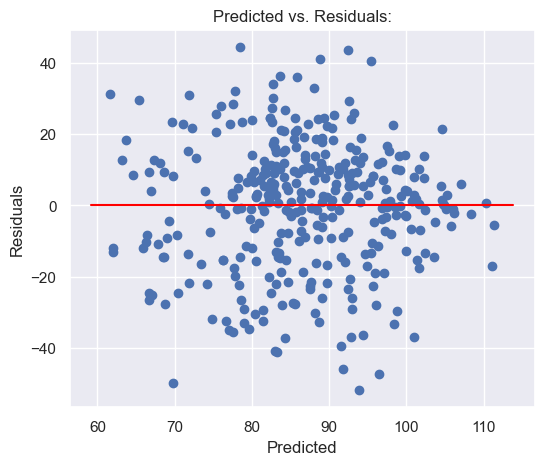

The result of the Goldfeld Quandt test is (0.8919003032012699, 0.7693101301052961, 'increasing')
We can not reject the null hypothesis that the residuals are homoscedastic


--------------------------------------------------------------------------------------------------------------


Check for Homoscedasticity


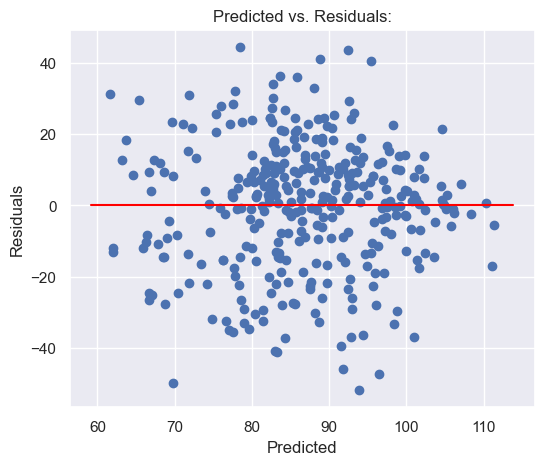

The result of the Goldfeld Quandt test is (0.8919003032012699, 0.7693101301052961, 'increasing')
We can not reject the null hypothesis that the residuals are homoscedastic


--------------------------------------------------------------------------------------------------------------


Check for Multicolinearity


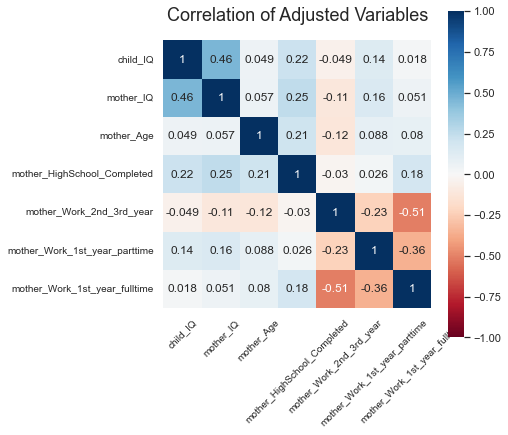

                                 feature        VIF
0                              mother_IQ   5.051646
1          mother_Work_1st_year_parttime   1.188487
2            mother_HighSchool_Completed  47.155087
3  mother_IQ:mother_HighSchool_Completed  51.077937


The variable ['mother_HighSchool_Completed', 'mother_IQ:mother_HighSchool_Completed'] are highly correlated


--------------------------------------------------------------------------------------------------------------


Check for Autocorrelation


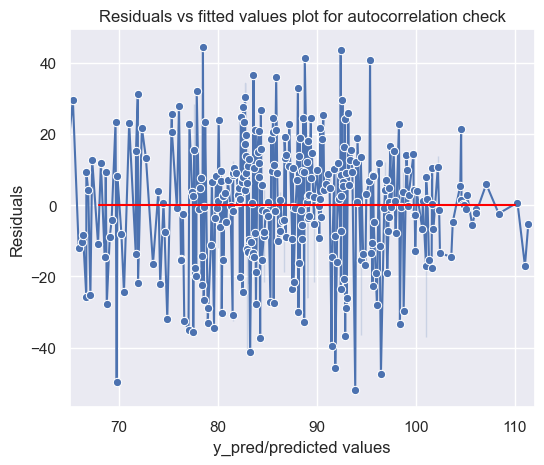

Durbin-Watson: 1.8616983066399342
There is little to no autocorrelation in residuals


In [49]:
Linearity(model3_2)
print("\n")
print("--------------------------------------------------------------------------------------------------------------")
print("\n")
Normality(model3_2)
print("\n")
print("--------------------------------------------------------------------------------------------------------------")
print("\n")
Homoscedasticity(model3_2)
print("\n")
print("--------------------------------------------------------------------------------------------------------------")
print("\n")
Homoscedasticity(model3_2)
print("\n")
print("--------------------------------------------------------------------------------------------------------------")
print("\n")
Multicolinearity(model3_2)
print("\n")
print("--------------------------------------------------------------------------------------------------------------")
print("\n")
Autocorrelation(model3_2)

#### Model Interpretation


\begin{equation*}
\begin{split}
Child\_IQ &= \beta_0 + \beta_1Mother\_IQ + \beta_2mother\_Work\_1st\_year\_parttime \\
&+\beta_3mother\_HighSchool\_Completed \\
&+\beta_4Mother\_IQ*mother\_HighSchool\_Completed \\
& + \epsilon \;\;\;\; \text{where} \; \epsilon \sim N(0,\sigma^2)
\end{split}
\end{equation*}




In [50]:
model3_2.params

Intercept                                -8.562299
mother_IQ                                 0.937586
mother_Work_1st_year_parttime             4.216267
mother_HighSchool_Completed              46.585545
mother_IQ:mother_HighSchool_Completed    -0.439215
dtype: float64

The coefficient of Intercept ($\beta_0$) is:  -8.56,

 meaning when all other variables in the model are 0, the child's IQ is predicted to be negative. (This is normal, but there might be adjustment needed, but normally we don't have mother's IQ == 0)

The coefficient of mother_IQ ($\beta_1$) is:  0.938,

 meaning by increasing 1 unit of mother_IQ the child's IQ increase 0.938 units with other variables fixed

The coefficient of mother_Work_1st_year_parttime ($\beta_2$) is:  4.22,

 meaning when mother worked parttime in 1st year of child's life, the child's IQ is 4.22 units higher than the child's IQ whose mother didn't, with other variables fixed.

The coefficient of mother_HighSchool_Completed ($\beta_3$) is:  46.6 and the coefficient of mother_IQ:mother_HighSchool_Completed ($\beta_4$) is:  -0.439, 

(1)

  when mother completed High School, the $child\_IQ = -8.56+0.938*mother\_IQ + 4.22 * mother\_Work\_1st\_year\_parttime + 46.6 -0.439 * mother\_IQ$. 
 
If the mother's IQ increases 1 unit, the child's IQ increases 0.938 -0.439 = 1.377 units with mother_Work_1st_year_parttime fixed. 


(2)

 when mother did not complete High School, the $child\_IQ = -8.56+0.938*mother\_IQ + 4.22 * mother\_Work\_1st\_year\_parttime $. 

If the mother's IQ increases 1 unit, the child's IQ increases 0.938 units with mother_Work_1st_year_parttime fixed. 

With both mother_Work_1st_year_parttime and mother_IQ fixed, the child's IQ whose mother completed high school is 46.6 -0.439 * mother_IQ higher/lower than the child whose mother didn't complete high school



In [51]:
model3_2.pvalues

Intercept                                5.582304e-01
mother_IQ                                5.448801e-09
mother_Work_1st_year_parttime            1.370010e-01
mother_HighSchool_Completed              4.874218e-03
mother_IQ:mother_HighSchool_Completed    1.150957e-02
dtype: float64

All variables have a relatively low p-value

The p-value of mother_IQ, mother_HighSchool_Completed,  mother_IQ:mother_HighSchool_Completed is statistically significant at a significance level of 0.05.

#### Evaluation Metrics

In [52]:
print(model3_1.aic)
print(model3_2.aic)

2997.923898976122
2994.3623393415037


In [53]:
metric_3 = metrics(model3_2)
metric_3

,train,test
mse,318.171572,318.802055
rmse,17.837364,17.855029
mae,14.035734,14.578585
R^2,0.242051,0.200673
Adj_R^2,0.233186,0.198356


### 4.4 Model Comparasion

In [55]:
metric_1.add_prefix('model1_').join(metric_2.add_prefix('model2_')).join(metric_3.add_prefix('model3_'))

,model1_train,model1_test,model2_train,model2_test,model3_train,model3_test
mse,330.735717,338.650964,324.17624,328.957106,318.171572,318.802055
rmse,18.186141,18.402472,18.004895,18.137175,17.837364,17.855029
mae,14.324302,14.911319,14.244781,14.812948,14.035734,14.578585
R^2,0.21212,0.150906,0.227746,0.175212,0.242051,0.200673
Adj_R^2,0.209837,0.148445,0.220992,0.172821,0.233186,0.198356


* Model 1: Single Predictor (mother_IQ)
* Model 2: Multiple Predictors (mother_IQ + mother_Work_1st_year_parttime + mother_HighSchool_Completed)
* Model 3: Multiple Predictors with (mother_IQ+mother_Work_1st_year_parttime + mother_HighSchool_Completed + mother_IQ*mother_HighSchool_Completed)

Model 3 has better overall performance.